In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import types
from botocore.client import Config
import ibm_boto3

sns.set(style = "darkgrid")
style.use("ggplot")

In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_test = pd.concat([train, test], sort=True).reset_index(drop = True)
train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [7]:
def divide_df(df):
    return df.iloc[:891], df.iloc[891:].drop("Survived", axis=1) # train,test

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [9]:
def print_missing_values(df):
        for col in df.columns.tolist():
            
            print("{} missing values: {}".format(col, df[col].isnull().sum()))
            
        print("\n")
            
print_missing_values(train)
print_missing_values(test)

PassengerId missing values: 0
Survived missing values: 0
Pclass missing values: 0
Name missing values: 0
Sex missing values: 0
Age missing values: 177
SibSp missing values: 0
Parch missing values: 0
Ticket missing values: 0
Fare missing values: 0
Cabin missing values: 687
Embarked missing values: 2


PassengerId missing values: 0
Pclass missing values: 0
Name missing values: 0
Sex missing values: 0
Age missing values: 86
SibSp missing values: 0
Parch missing values: 0
Ticket missing values: 0
Fare missing values: 1
Cabin missing values: 327
Embarked missing values: 0




In [10]:
# Extract Title out of Name
train_test["Title"] = train_test["Name"].str.split(", ", expand=True)[1].str.split(". ", expand=True)[0]

train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [11]:
# Sex Pclass and Title seem to have significant impact on age
train_test.groupby(["Sex", "Pclass", "Title"])["Age"].agg("median")

Sex     Pclass  Title   
female  1       Dona        39.0
                Dr          49.0
                Lady        48.0
                Miss        30.0
                Mlle        24.0
                Mme         24.0
                Mrs         45.0
                th          33.0
        2       Miss        20.0
                Mrs         30.5
                Ms          28.0
        3       Miss        18.0
                Mrs         31.0
                Ms           NaN
male    1       Capt        70.0
                Col         54.5
                Don         40.0
                Dr          47.0
                Jonkheer    38.0
                Major       48.5
                Master       6.0
                Mr          41.5
                Sir         49.0
        2       Dr          38.5
                Master       2.0
                Mr          30.0
                Rev         41.5
        3       Master       6.0
                Mr          26.0
Name: Age, dtype: 

In [12]:
# Fill in missing age values with median of their group regarding Pclass, Sex and Title
train_test["Age"] = train_test.groupby(["Sex", "Pclass"])["Age"].apply(lambda x: x.fillna(x.median()))
train_test.head(20)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr
5,25.0,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,Mr
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,Mr
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,Master
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,Mrs
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,Mrs


In [13]:
print(train_test["Cabin"].unique())

[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148' 'B45' 'B36' 'A21' 'D34' 'A9' 'C31' 'B61' 'C5

In [14]:
# First letter of Cabin encodes the deck
# Extract Deck and fill in M for missing values
train_test["Deck"] = train_test["Cabin"].apply(lambda s: s[0] if pd.notnull(s) else "M")
train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Deck
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,M
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,C
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,M
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,C
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,M


In [15]:
train_test["Deck"].unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [16]:
# Test DataFrame for Data Exploration only 
test_df = train_test.copy()
# Transform Pclass to dummies in order to graph them later
pclasses = pd.get_dummies(test_df["Pclass"], prefix="Pclass")
test_df = pd.concat([test_df, pclasses], axis=1)
test_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Deck,Pclass_1,Pclass_2,Pclass_3
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,M,0,0,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,C,1,0,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,M,0,0,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,C,1,0,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,M,0,0,1


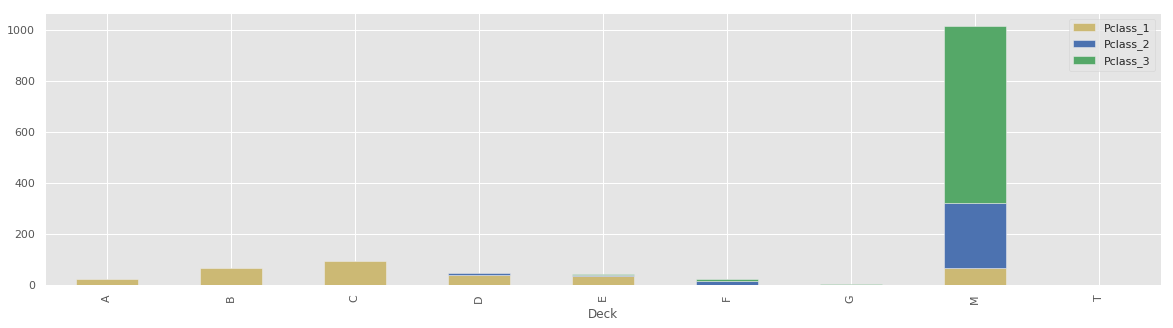

In [17]:
# Pclass Disitribution for each deck.
test_df.groupby("Deck")[["Pclass_1", "Pclass_2", "Pclass_3"]].agg("sum").plot(kind="bar", stacked=True, color=["y", "b", "g"], figsize=(20,5))

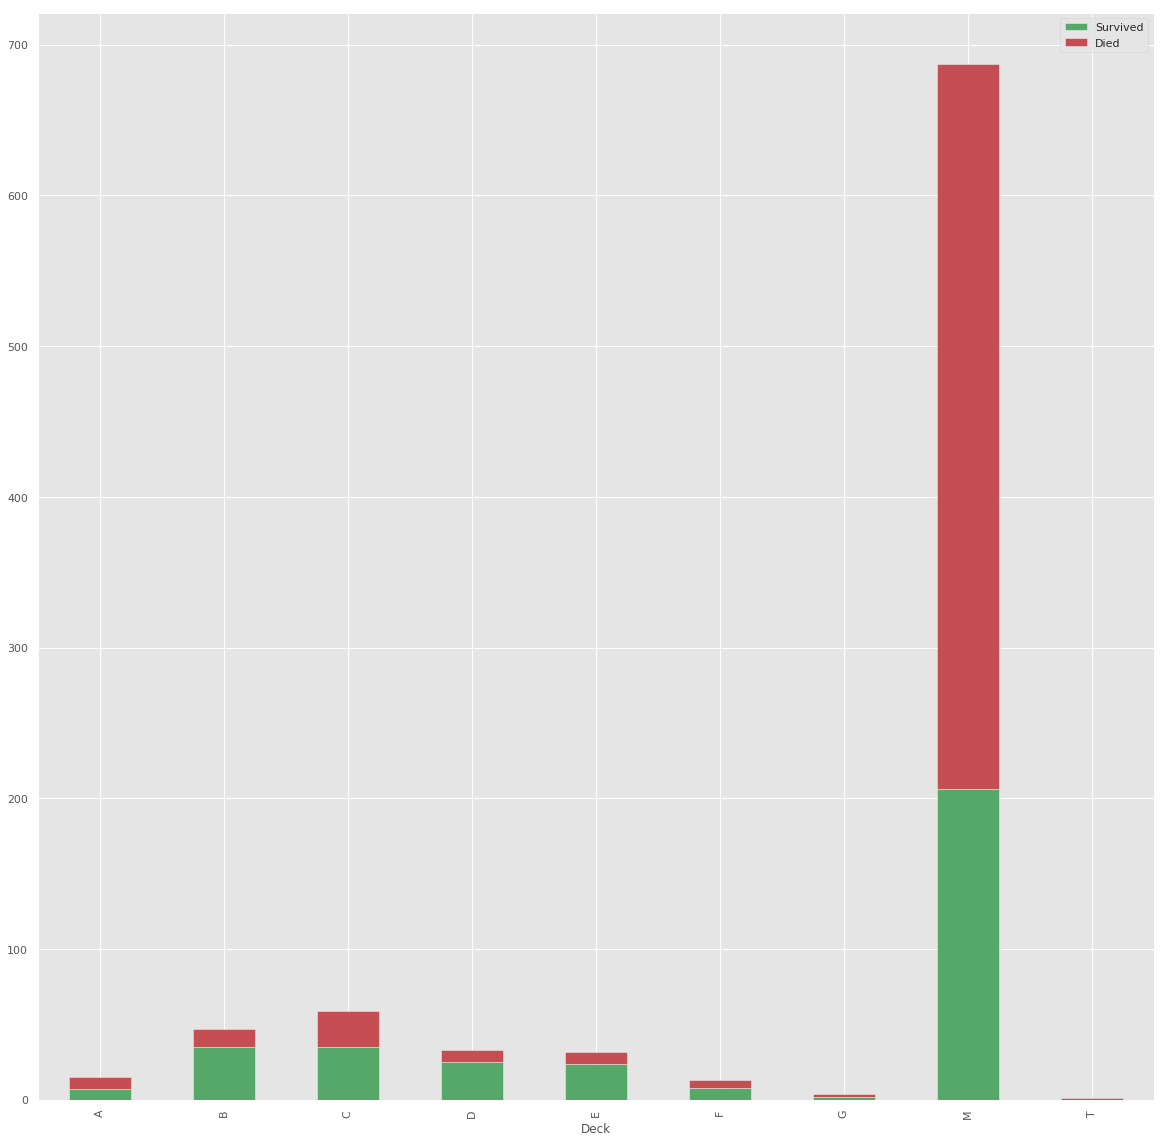

In [18]:
# Survival rate of each deck
test_df["Died"] = 1 - test_df["Survived"]
test_df.groupby("Deck")[["Survived", "Died"]].agg("sum").plot(kind="bar", stacked=True, color=["g", "r"], figsize=(20,20))

In [19]:
# group decks:
# Deck A and T only 1st class, but lower survival rate than B and C
train_test["Deck"].replace(["A", "T"],"A",inplace=True)
# Only 1st Class and same survival rate
train_test["Deck"].replace(["B", "C"],"BC",inplace=True)
# Each group same passenger and survival distribution
train_test["Deck"].replace(["D", "E"],"DE",inplace=True)
train_test["Deck"].replace(["F", "G"],"FG", inplace=True)

train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Deck
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,M
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,BC
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,M
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,BC
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,M


In [20]:
# Cabin got replaced by Deck
train_test.drop("Cabin", axis=1, inplace=True)

In [21]:
# Compute Family Size out of number of parents + siblings and spouse and the entry itself
train_test["Family_size"] = train_test["Parch"] + train_test["SibSp"] + 1
train_test.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Deck,Family_size
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,M,2
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,BC,2
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,M,1
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,BC,2
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,M,1


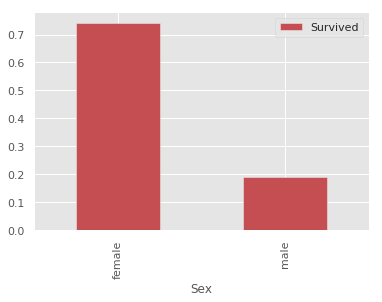

In [22]:
# Distribution of survivers in regards to Sex
train_test.iloc[:890].groupby(["Sex"])[["Survived"]].agg("mean").plot(kind="bar", color=["r", "g"])

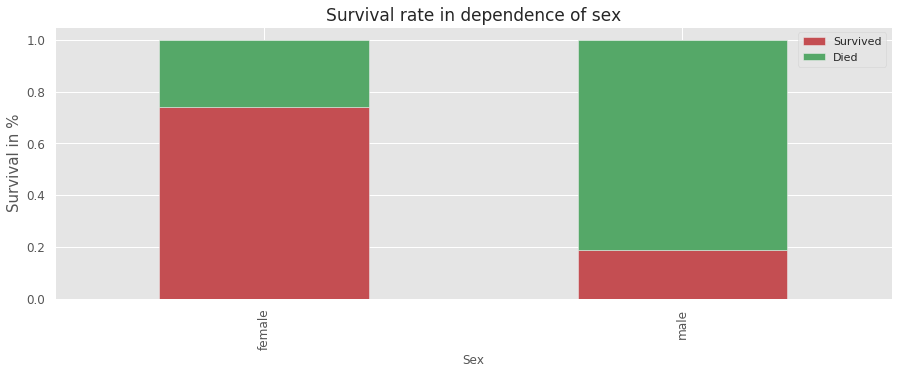

In [30]:
# Survival rate depending on Sex
# Use test_df to avoid unnecessary column in train_test df
test_df["Died"] = 1 - test_df["Survived"]
test_df.iloc[:890].groupby(["Sex"])[["Survived", "Died"]].agg("mean").plot(kind="bar", stacked=True, color=["r", "g"], figsize=(15, 5), )
plt.title("Survival rate in dependence of sex", fontsize = 17)
plt.ylabel("Survival in %", fontsize = 15)
plt.tick_params(axis = "both", labelsize = 12)
plt.show()

In [31]:
train_test.drop("Unnamed: 0", axis=1, inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [32]:
# Correlation
corr = train_test.drop("PassengerId", axis=1)
# turn Sex binary to enable correlating it
corr["Sex"] = corr["Sex"].map({"male":0, "female":1})
corr = corr.corr()
corr

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,Family_size
Age,1.000000,0.200039,-0.134239,-0.451983,-0.074529,-0.204025,-0.058635,-0.207570
Fare,0.200039,1.000000,0.221539,-0.558629,0.185523,0.160238,0.257307,0.226492
Parch,-0.134239,0.221539,1.000000,0.018322,0.213125,0.373587,0.081629,0.792296
Pclass,-0.451983,-0.558629,0.018322,1.000000,-0.124617,0.060832,-0.338481,0.050027
Sex,-0.074529,0.185523,0.213125,-0.124617,1.000000,0.109609,0.543351,0.188583
SibSp,-0.204025,0.160238,0.373587,0.060832,0.109609,1.000000,-0.035322,0.861952
Survived,-0.058635,0.257307,0.081629,-0.338481,0.543351,-0.035322,1.000000,0.016639
Family_size,-0.207570,0.226492,0.792296,0.050027,0.188583,0.861952,0.016639,1.000000


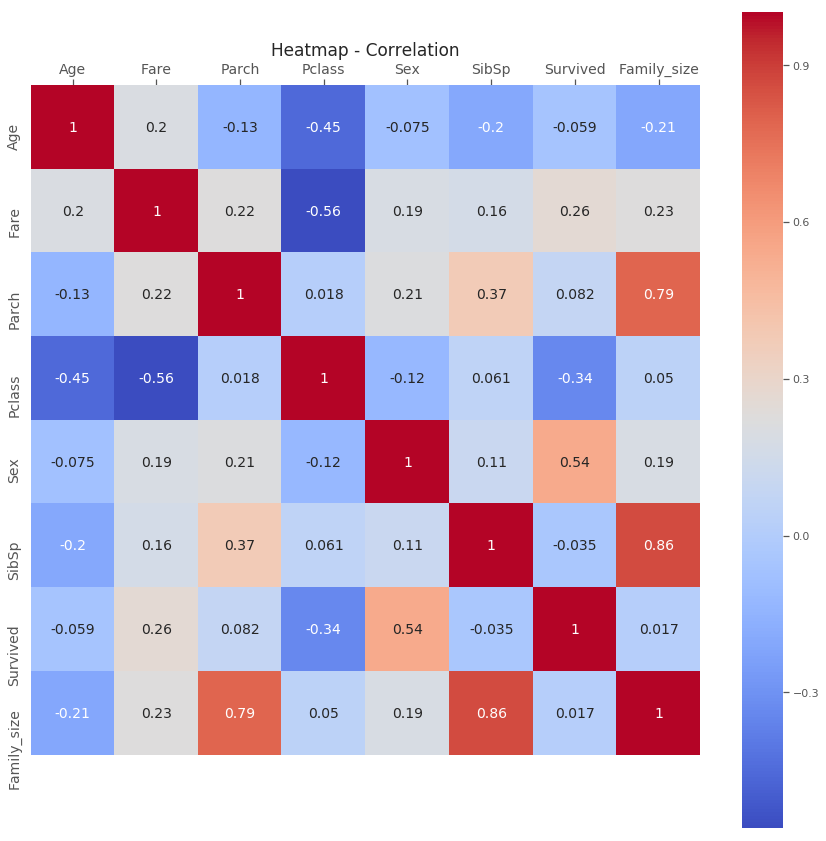

In [37]:
# PLot the correlation
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(1, 1, 1)

sns.heatmap(corr, annot=True, square=True, cmap="coolwarm", annot_kws={"size":14})

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

#ax.set_xticks(np.arange(corr.shape[0] + 0.5), minor=False)
#ax.set_yticks(np.arange(corr.shape[1] + 0.5), minor=False)
#ax.invert_yaxis()
ax.xaxis.tick_top()

#ax.set_xticklabels(corr.columns)
#ax.set_yticklabels(corr.index)
ax.set_title("Heatmap - Correlation", fontsize = 17)
ax.title.set_position([0.5, 10.0])
#fig.colorbar(heatmap)
plt.show()

In [ ]:
# Comments: Family size, Parch and SibSp are obvious outlyers as we computed family size of the latter two.
# Also having parents increrases the chance of having siblings signifcantly and vise versa
# The focus lies on the correlation in regards to Survived. Sex, Fare and Pclass have the highest correlation.

In [38]:
train_test.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Deck,Family_size
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,M,2
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,BC,2
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,M,1
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,BC,2
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,M,1


### Feature Encoding

In [40]:
train_test["Sex"].replace(["male", "female"],[0,1], inplace = True)
train_test.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Deck,Family_size
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,Mr,M,2
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,Mrs,BC,2
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,Miss,M,1
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,Mrs,BC,2
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,Mr,M,1


In [45]:
train, test = divide_df(train_test)
test.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Title,Deck,Family_size
891,34.5,Q,7.8292,"Kelly, Mr. James",0,892,3,0,0,330911,Mr,M,1
892,47.0,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,1,1,363272,Mrs,M,2
893,62.0,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,0,0,240276,Mr,M,1
894,27.0,S,8.6625,"Wirz, Mr. Albert",0,895,3,0,0,315154,Mr,M,1
895,22.0,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,1,1,3101298,Mrs,M,3


In [50]:
feature_df = train[["Age", "Sex", "Fare", "Family_size"]]
feature_df.head()

,Age,Sex,Fare,Family_size
0,22.0,0,7.2500,2
1,38.0,1,71.2833,2
2,26.0,1,7.9250,1
3,35.0,1,53.1000,2
4,35.0,0,8.0500,1


In [51]:
feature_df = pd.concat([feature_df, pd.get_dummies(train["Pclass"])], axis = 1)
feature_df = pd.concat([feature_df, pd.get_dummies(train["Deck"])], axis = 1)
feature_df.head()

,Age,Sex,Fare,Family_size,1,2,3,A,BC,DE,FG,M
0,22.0,0,7.2500,2,0,0,1,0,0,0,0,1
1,38.0,1,71.2833,2,1,0,0,0,1,0,0,0
2,26.0,1,7.9250,1,0,0,1,0,0,0,0,1
3,35.0,1,53.1000,2,1,0,0,0,1,0,0,0
4,35.0,0,8.0500,1,0,0,1,0,0,0,0,1


In [52]:
X = feature_df
y = train["Survived"].values

## Classification

#### In this section we will try to predict wether a passenger survived or not with help of the following four algorithms:

- K Nearest Neighbor
- Decision tree
- Support Vector Machine
- Logistic Regression

## K Nearest Neighbor

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#### First: find the best k
We keep the test set to train our model later. So for finding the best k, lets split the train set into test and train using the train_test_split function from sklearn.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

# Lets try k for 1 - 20
neighbors = 20
mean_acc = np.zeros((neighbors - 1))
std_acc = np.zeros((neighbors - 1))

for k  in range(1, neighbors):
    
    nbrs = KNeighborsClassifier(n_neighbors = k)
    nbrs.fit(X_train, y_train)
    y_pred = nbrs.predict(X_test)
    
    mean_acc[k-1] = np.mean(y_pred == y_test)
    std_acc[k-1] = np.std(y_pred == y_test) / np.sqrt(y_pred.shape[0])
    
print("mean: {}\n std: {}".format(mean_acc, std_acc))

mean: [0.71525424 0.71525424 0.73220339 0.7220339  0.72881356 0.71864407
 0.71864407 0.72881356 0.69491525 0.70169492 0.67118644 0.68474576
 0.69491525 0.70169492 0.68813559 0.70169492 0.68135593 0.69830508
 0.68474576]
 std: [0.02627531 0.02627531 0.02578145 0.02608337 0.02588399 0.02618026
 0.02618026 0.02588399 0.02680805 0.0266375  0.02735177 0.02705105
 0.02680805 0.0266375  0.02697174 0.0266375  0.0271287  0.02672364
 0.02705105]


#### The best k seems to be 3, with a mean of 0.7322 and a std of 0.0257. So lets go with that.

In [59]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

## Decision Tree

In [60]:
from sklearn.tree import DecisionTreeClassifier

### Find the optimal depth of the tree with the same method as in KNN

In [63]:
depth = 20
mean_acc = np.zeros((depth - 1))
std_acc = np.zeros((depth - 1))

for d in range(1,depth):
    
    tree = DecisionTreeClassifier(criterion = "entropy", max_depth = d)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    
    mean_acc[d-1] = np.mean(y_pred == y_test)
    std_acc[d-1] = np.std(y_pred == y_test) / np.sqrt(y_pred.shape[0])
    
mean_acc

array([0.78644068, 0.78644068, 0.76271186, 0.82372881, 0.82711864,
       0.83728814, 0.82711864, 0.82711864, 0.79322034, 0.84745763,
       0.78305085, 0.81694915, 0.80677966, 0.8       , 0.8       ,
       0.80338983, 0.76610169, 0.81016949, 0.79322034])

#### The best depth seems to be 10 with a mean accuracy of 0.847.

In [64]:
tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 10)
tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')